
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>
 
 
# Laboratorio: Análisis y Modelado de Series Temporales con SARIMAX

En este laboratorio, practicarás el análisis y modelado de series temporales utilizando el modelo SARIMAX. 
Objetivos del laboratorio

- Analizar series temporales:
	
    - Identificar tendencias, estacionalidad y posibles rupturas estructurales en los datos.
	
    - Verificar la estacionaridad de la serie mediante pruebas estadísticas y visuales.
	
    - Realizar análisis de autocorrelación (ACF) y autocorrelación parcial (PACF).

- Modelar la serie temporal:
	
    - Ajustar un modelo SARIMAX adecuado para los datos proporcionados.
	
    - Evaluar los resultados del modelo e interpretar los parámetros obtenidos.

- Interpretar gráficas y resultados:
	
    - Explicar de forma detallada el significado de las gráficas y resultados generados durante cada etapa del análisis.

# Instrucciones

- Parte 1: Carga y exploración inicial de los datos

    - Descarga el conjunto de datos proporcionado, que contiene una serie temporal de valores relacionados con ventas mensuales de una empresa ficticia durante los últimos 5 años.

    - Realiza una exploración inicial:

        - Gráfica la serie temporal completa para identificar posibles tendencias y estacionalidades.

        - Comenta tus observaciones iniciales sobre los patrones que encuentres.

- Parte 2: Estacionaridad


    - Evalúa si la serie es estacionaria:

    - Aplica el test de Dickey-Fuller aumentado (ADF).

    - Si es necesario, realiza transformaciones (diferenciación o logaritmos) para convertir la serie en estacionaria.

    - Genera una gráfica comparativa que muestre la serie original y la transformada, indicando las diferencias visuales.

    - Escribe una interpretación de los resultados del test ADF y de la gráfica.

- Parte 3: Análisis de autocorrelaciones


    - Genera los gráficos de ACF (Autocorrelation Function) y PACF (Partial Autocorrelation Function).

    - Identifica:

        - El orden de diferenciación necesario (si aún no lo has hecho).

        - Los posibles valores para los parámetros p y q del modelo SARIMAX.

    - Explica qué indican las autocorrelaciones encontradas y cómo las utilizarás para definir los parámetros del modelo.

- Parte 4: Ajuste del modelo SARIMAX


    - Ajusta un modelo SARIMAX utilizando los parámetros identificados.

    - Evalúa el ajuste:

        - Observa los residuos del modelo.

        - Verifica si cumplen las condiciones de ruido blanco mediante análisis visual y pruebas estadísticas.

    - Ajusta el modelo si es necesario, iterando sobre los parámetros.

- Parte 5: Interpretación y predicción


    - Interpreta los coeficientes estimados del modelo (incluyendo estacionalidad y efectos externos si aplican).

    - Genera una predicción para los próximos 12 meses.

    - Gráfica las predicciones junto con la serie temporal original.

    - Comenta sobre:

        - La calidad de las predicciones.

        - La utilidad del modelo para la toma de decisiones.



In [287]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Analisis Exploratorio Series Temporales
# -----------------------------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product

# Otros
# -----------------------------------------------------------------------
from tqdm import tqdm

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('src') #pongo los 2 puntos para que salga de la carpeta
import src.soporte_sarima as ss
import src.funciones as f
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
df = pd.read_csv('datos/Truck_sales.csv')
df.head()

,Month-Year,Number_Trucks_Sold
0,03-Jan,155
1,03-Feb,173
2,03-Mar,204
3,03-Apr,219
4,03-May,223


## EDA

- No tengo duplicados, los 144 datos corresponden a los 12 meses de 12 años.

In [289]:
f.exploracion_dataframe(df)

El número de datos es 144 y el de columnas es 2

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Month-Year,object
Number_Trucks_Sold,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna Month-Year tiene los siguientes valores únicos:


,count
Month-Year,
03-Jan,1
03-Feb,1
10-Sep,1
10-Oct,1
10-Nov,1
...,...
07-Jan,1
07-Feb,1
07-Mar,1


In [290]:
df.dtypes

Month-Year            object
Number_Trucks_Sold     int64
dtype: object

In [291]:
df['Month-Year'] = pd.to_datetime(df['Month-Year'], format='%y-%b').dt.strftime('%y-%m')

In [292]:
df['Month-Year'] = pd.to_datetime(df['Month-Year'], format='%y-%m')

In [293]:
df.dtypes

Month-Year            datetime64[ns]
Number_Trucks_Sold             int64
dtype: object

In [294]:
# # instanciamos la clase
# analisis_st = ss.TimeSeriesAnalysis(df, temporal_column="Month-Year", value_column="Number_Trucks_Sold")

# analisis_st.exploracion_datos()

- Al tomar en mi clase solo la columna de Number_Trucks_Sold puede identificar algunos duplicados pero estos en realidad son la repetición de algunos valores de mi columna (esto es totalmente normal)

In [295]:
df.duplicated().sum()

0

In [296]:
df_copia = df.copy()
df_copia["Date"] = pd.to_datetime(df_copia["Month-Year"])
df_copia["Month"] = df_copia["Date"].dt.month_name()
df_copia["Year"] = df_copia["Date"].dt.year
df_copia.head()

,Month-Year,Number_Trucks_Sold,Date,Month,Year
0,2003-01-01,155,2003-01-01,January,2003
1,2003-02-01,173,2003-02-01,February,2003
2,2003-03-01,204,2003-03-01,March,2003
3,2003-04-01,219,2003-04-01,April,2003
4,2003-05-01,223,2003-05-01,May,2003


- Creo mi copia de data frame, junto a las columnas de mes y año.

In [297]:
df_copia.head()

,Month-Year,Number_Trucks_Sold,Date,Month,Year
0,2003-01-01,155,2003-01-01,January,2003
1,2003-02-01,173,2003-02-01,February,2003
2,2003-03-01,204,2003-03-01,March,2003
3,2003-04-01,219,2003-04-01,April,2003
4,2003-05-01,223,2003-05-01,May,2003


In [298]:
# instanciamos la clase
analisis_st = ss.TimeSeriesAnalysis(df_copia, temporal_column="Month-Year", value_column="Number_Trucks_Sold")

analisis_st.exploracion_datos()

El número de filas es 144 y el número de columnas es 4

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,min,25%,50%,75%,max,std
Number_Trucks_Sold,144,429,152,274,406,560,958,189
Date,144,2008-12-15 17:00:00,2003-01-01 00:00:00,2005-12-24 06:00:00,2008-12-16 12:00:00,2011-12-08 18:00:00,2014-12-01 00:00:00,NaN
Year,144,2008,2003,2006,2008,2011,2014,3


In [299]:
df_copia.set_index('Date', inplace=True)
# df_copia.index.name = 'Date'

In [300]:
df_copia.head()

,Month-Year,Number_Trucks_Sold,Month,Year
Date,,,,
2003-01-01,2003-01-01,155,January,2003
2003-02-01,2003-02-01,173,February,2003
2003-03-01,2003-03-01,204,March,2003
2003-04-01,2003-04-01,219,April,2003
2003-05-01,2003-05-01,223,May,2003


In [301]:
df_copia.drop(columns='Month-Year', inplace=True)

In [302]:
df_copia.head()

,Number_Trucks_Sold,Month,Year
Date,,,
2003-01-01,155,January,2003
2003-02-01,173,February,2003
2003-03-01,204,March,2003
2003-04-01,219,April,2003
2003-05-01,223,May,2003


In [303]:
df.set_index('Month-Year', inplace=True)

In [304]:
df_copia.shape

(144, 3)

In [305]:
df_copia['Month'].value_counts()

Month
January      12
February     12
March        12
April        12
May          12
June         12
July         12
August       12
September    12
October      12
November     12
December     12
Name: count, dtype: int64

Confirmo que mis meses son repetidos 12 veces

### Continua

In [306]:
analisis_st.comprobar_serie_continua()

La serie temporal es continua, no faltan meses.


### Evolución de mi serie temporal en el tiempo

In [307]:
analisis_st.graficar_serie()

Con este primer acercamiento, puedo confirmar que mi serie tiene tendencia a aumentar en el tiempo. Es cierto que antes del 2007 se ve cierto ruido en años anterior pero aunque era ligero, era visible un aumento. A partir de este año se reduce el ruido pero se aclara más el alza producida hasta el 2012. Después de aquí los valores siguen aumentando pero se presenta algo más de ruido.

In [308]:
analisis_st.graficar_media_movil(window=12)

La línea roja es lo que me confirma la tendencia positiva de aumento.

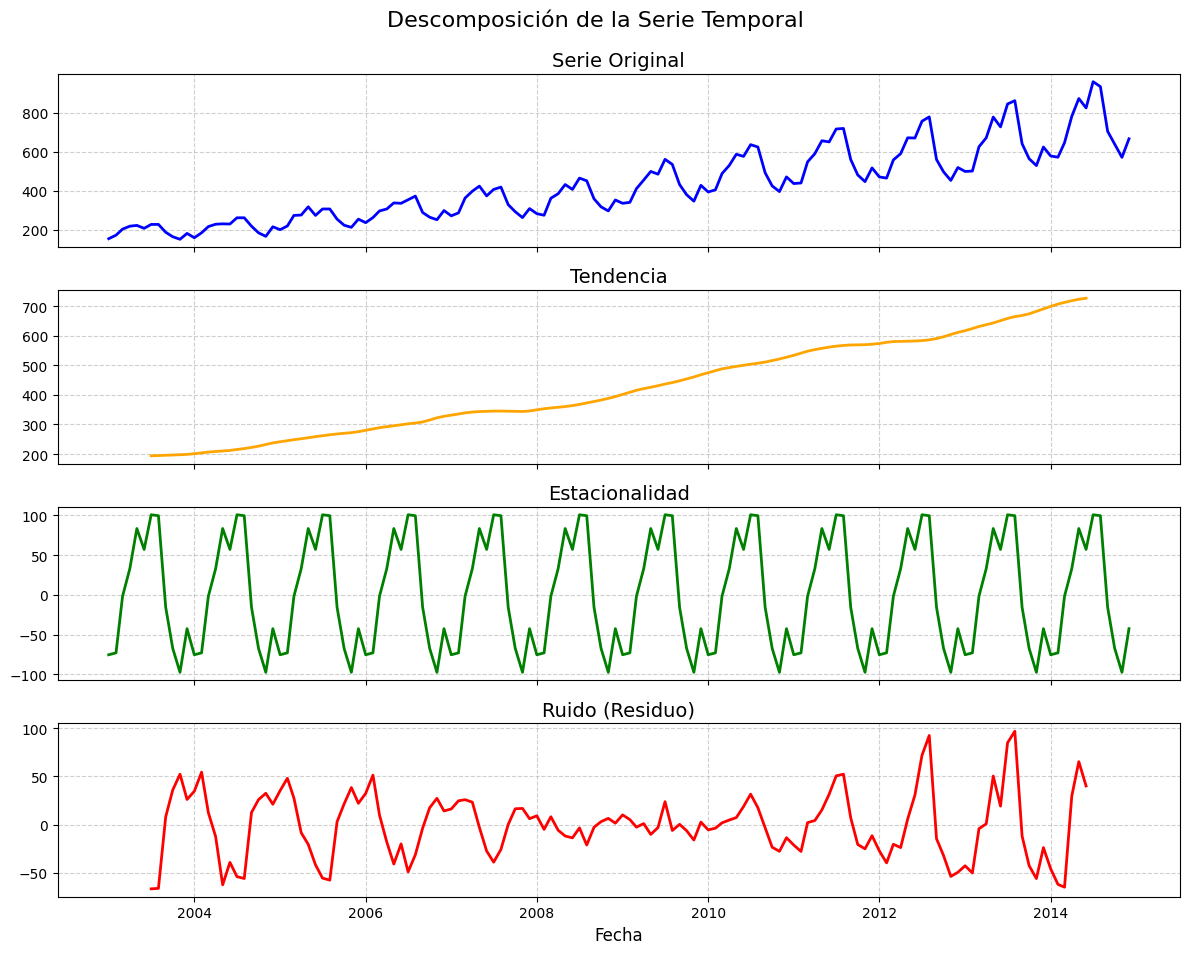

In [309]:
analisis_st.detectar_estacionalidad()

Existe tendencia a lo largo del tiempo pero a la vez existe estacionalidad, lo que demuestra que en estos cambios suelen producirse en las mismas épocas del año para los años contenidos en mis datos. Con relación al ruido, hay un ruido inicial que se diluye entre el 2007-2012 para luego crecer un poco más.

## Correlación

<Figure size 1200x1000 with 0 Axes>

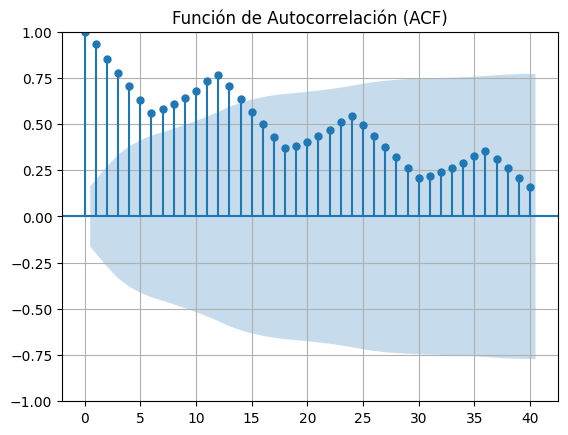

<Figure size 1200x1000 with 0 Axes>

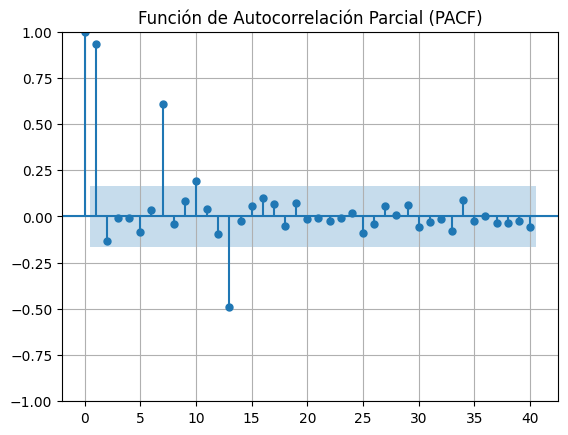

In [310]:
analisis_st.graficar_acf_pacf(lags=40)

- ACF: Picos significativos en intervalos regulares: Indican estacionalidad. Se pueden ver picos cada 6 lags, por lo que tenemos un patrón cada 6 meses que hace que rebote la autocorrelación. Decaimiento no muy lento pero que vuelve a subir.

La ACF comienza con una correlación alta (en el *lag* 1) y disminuye gradualmente a medida que los *lags* aumentan. Este comportamiento indica que los valores actuales de la serie están influenciados no solo por los valores inmediatamente anteriores, sino también por los valores en *lags* más lejanos.

- Valores significativos a largo plazo:
	
    - Muchas barras permanecen por encima del intervalo de confianza sombreado, incluso en *lags* mayores a 10 o 15. Esto refuerza la idea de que existe una dependencia a largo plazo en la serie, probablemente debido a la presencia de una tendencia subyacente.

- Ausencia de estacionalidad evidente:
	
    - Aunque los valores de la ACF son significativos para múltiples *lags*, no hay un patrón regular de picos (como en *lags* 12, 24, 36 para datos mensuales). Esto sugiere que la estacionalidad no es un componente dominante en la serie.

- PACF: 

### Estacionariedad

In [311]:
analisis_st.prueba_estacionariedad()

ADF Statistic: 1.1158932574252591
p-value: 0.9953500083802601
Valores Críticos:
1%: -3.482087964046026
5%: -2.8842185101614626
10%: -2.578864381347275
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


Métodos usando src de Ana

In [312]:
train_size = int(0.7 * len(df))
y_train, y_test = df[:train_size], df[train_size:]

Entreno mi modelo con el 70% de los datos

In [313]:
# Definir los rangos para los parámetros
sarima = ss.SARIMAModel()

p_range = range(4)
q_range = range(11)
seasonal_order_ranges = (
    range(2),  # P
    range(2),  # D
    range(2),  # Q
    [12]       # S
)

# Generar parámetros
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)
parametros[:5] # Ver algunas combinaciones

[(0, 0, (0, 0, 0, 12)),
 (0, 0, (0, 0, 1, 12)),
 (0, 0, (0, 1, 0, 12)),
 (0, 0, (0, 1, 1, 12)),
 (0, 0, (1, 0, 0, 12))]

  0%|          | 0/352 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodel

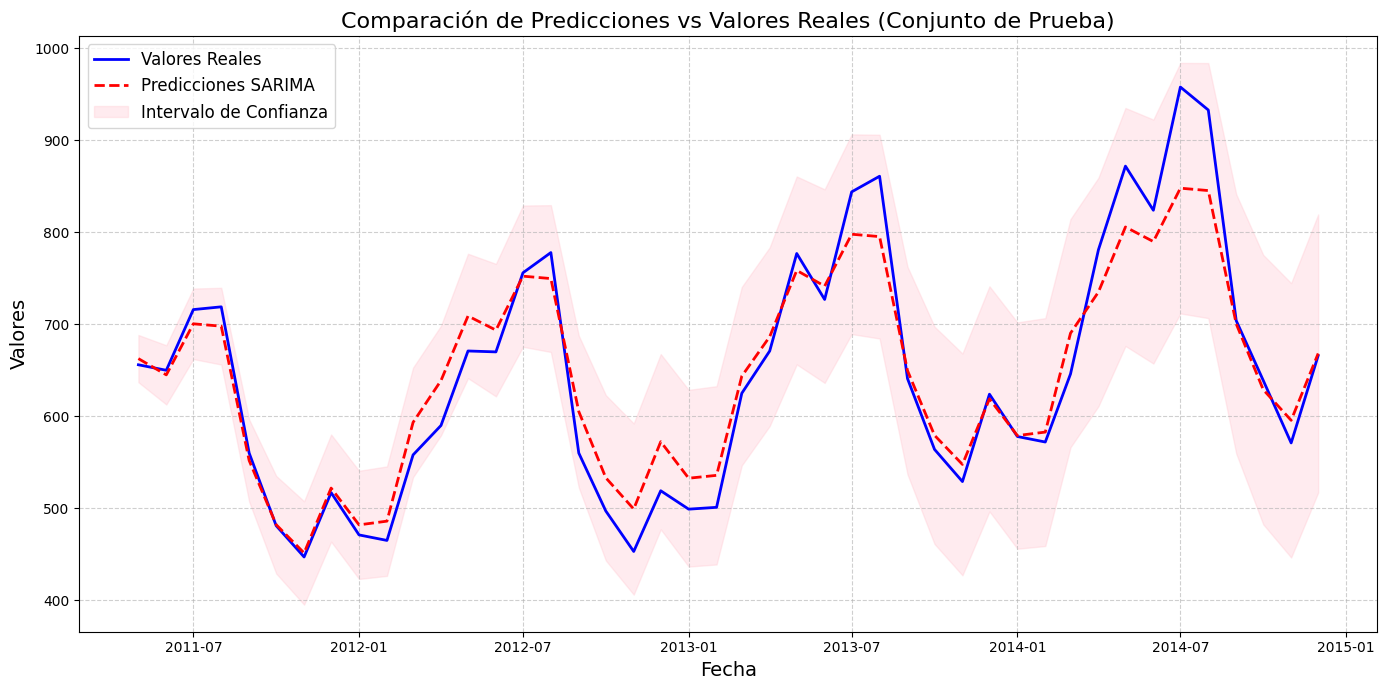

In [314]:
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, diferenciacion=1, df_length=len(df), variable="Number_Trucks_Sold")

De esta forma puedo visualizar los valores reales con las predicciones realizadas

results

In [315]:

# Ordenar resultados por RMSE
results_df = results_df.sort_values(by="RMSE", ascending=True)
results_df.head()

,p,q,seasonal_order,RMSE
87,0,10,"(1, 1, 1, 12)",36
220,2,5,"(1, 0, 0, 12)",36
255,2,9,"(1, 1, 1, 12)",36
159,1,8,"(1, 1, 1, 12)",36
175,1,10,"(1, 1, 1, 12)",37


## Métricas

In [324]:
datos_test = int(df.shape[0] * 0.3)
y_train = df.iloc[:-datos_test]
y_test = df.iloc[-datos_test:]
ps= range(4)
qs = range(11)

In [325]:
combinaciones = list(product(ps,qs)) # hago mis combinaciones
combinaciones[:6]

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

In [326]:
len(combinaciones)

44

In [327]:
len(df) - 1

143

In [328]:
resultados = {'p': [], 'q': [], 'rmse': []}
for p,q in combinaciones:
    modelo_sarima = SARIMAX(
        y_train,
        order = (p, 1, q), #p-d-q
        seasonal_order= (1,1,1,12)).fit()

    pred_y_test = modelo_sarima.predict(start=len(y_train), end=len(df)-1) # desde el final del ytrain a el final del df original

    rmse = np.sqrt(mean_squared_error(pred_y_test, y_test))
    resultados['p'].append(p)
    resultados['q'].append(q)
    resultados['rmse'].append(rmse)

pd.DataFrame(resultados).sort_values(by='rmse', ascending=True)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarni

,p,q,rmse
43,3,10,36
41,3,8,40
42,3,9,40
36,3,3,41
39,3,6,41
38,3,5,42
32,2,10,42
27,2,5,43
15,1,4,44
26,2,4,44


In [330]:
modelo_sarima_2 = SARIMAX(
    y_train,
    order = (3, 1, 10), #p-d-q
    seasonal_order= (1,1,1,12) # p-d-q-S
).fit()

pred_y_test = modelo_sarima.predict(start=len(y_train), end=len(df)-1) # desde el final del ytrain a el final del df original


y_test['predichos'] = pred_y_test.astype(int)
y_test

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceW

,Number_Trucks_Sold,predichos
Month-Year,,
2011-06-01,650,644
2011-07-01,716,710
2011-08-01,719,692
2011-09-01,560,557
2011-10-01,481,485
2011-11-01,447,442
2011-12-01,517,515
2012-01-01,471,481
2012-02-01,465,496


Text(0.5, 1.0, 'Predicción del y_test de la venta de camiones')

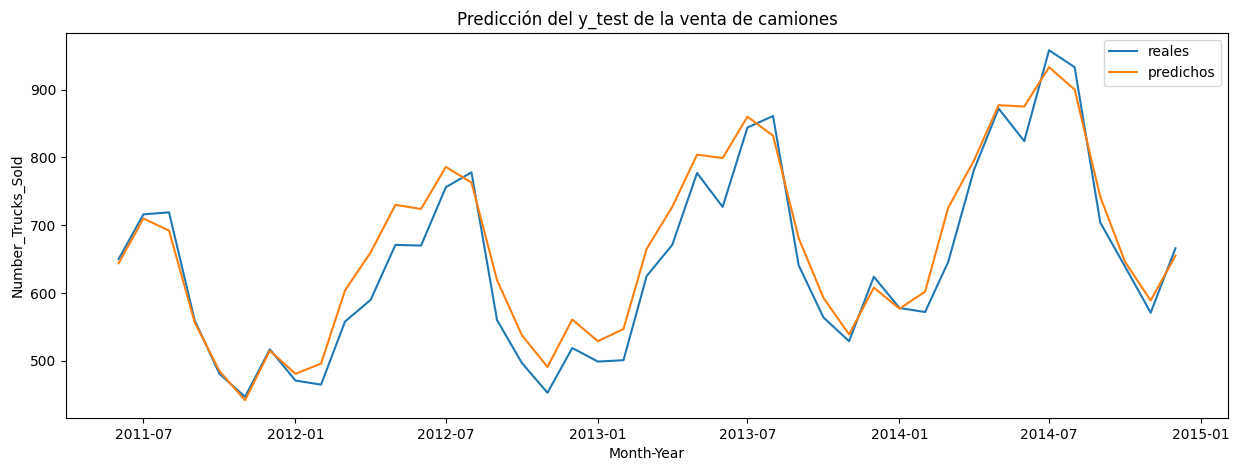

In [342]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='Number_Trucks_Sold', data=y_test, label='reales', legend=True)
sns.lineplot(x=y_test.index, y='predichos', data=y_test, label='predichos', legend=True)
plt.title('Predicción del y_test de la venta de camiones')

## Prediccion a futuro 

In [ ]:
modelo_sarima= SARIMAX(df, 
                    order= (3,1,10),                    #Se pone la p, la d y la q
                    seasonal_order= (1,1,1,12)).fit()   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df), end=len(df)+24)   #pongo el más 30 porque son los que quiero predecir

pred_y= pred_y.astype(int)
datos_predichos=pd.DataFrame(pred_y)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [335]:
datos_predichos

,predicted_mean
2015-01-01,634
2015-02-01,607
2015-03-01,720
2015-04-01,830
2015-05-01,927
2015-06-01,876
2015-07-01,1009
2015-08-01,981
2015-09-01,761
2015-10-01,687


Text(0.5, 1.0, 'Predicción a futuro de la venta de camiones')

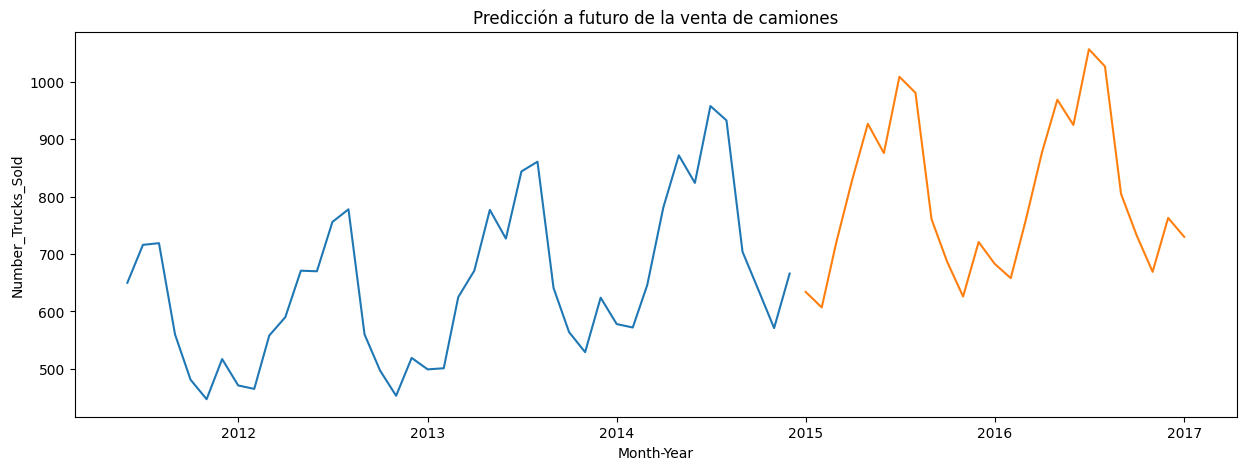

In [338]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='Number_Trucks_Sold', data=y_test)
sns.lineplot(x=datos_predichos.index, y='predicted_mean', data=datos_predichos)
plt.title('Predicción a futuro de la venta de camiones')